<a href="https://colab.research.google.com/github/PSergey24/jupyter_notebooks/blob/main/toxic_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Бинарный классификатор, максимизировать количество удаленных комментариев. Не хотим удалять плохие комментарии, 1/20 случаев можем ошибиться. 
# Recall: соотношение найденных плохих комментариев, 1 - нашли все плохие комментарии
# Precision: вероятность того, что если мы сказали комментарий плохой, то он таким и является. Не ниже 0.95
# максимизировать Recall, имея Precision не ниже порога

In [ ]:
# важно, чтобы тестовый датасет имел такое же распределение как и данные в production system
# можно найти другой датасет, но также разметить частично на наших данных, чтобы проверять

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/data/toxic_comments.csv', sep=',')

In [8]:
df['toxic'] = df['toxic'].apply(int)
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [9]:
df['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [10]:
for c in df[df['toxic'] == 1]['comment'].head(5):
  print(c)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [11]:
for c in df[df['toxic'] == 0]['comment'].head(5):
  print(c)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [12]:
train_df, test_df = train_test_split(df, test_size=500)

In [13]:
test_df.shape

(500, 2)

In [16]:
sentence_example = df.iloc[1]["comment"]
tokens = word_tokenize(sentence_example, language="russian")
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words("russian")
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language="russian")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

In [17]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [19]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [20]:
features = vectorizer.fit_transform(train_df['comment'])

In [21]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df['toxic'])

LogisticRegression(random_state=0)

In [23]:
model.predict(features[0]), train_df['comment'].iloc[0]

(array([0]),
 'Да. Закон не устанавливает требований к оформлению простых письменных договоров, поэтому, простая расписка, написанная от руки, может оформлять любой договор, для которого специально не установлена нотариальная форма - лишь бы из расписки можно было определить существенные условия договора. Так, для купли-продажи это предмет (что продается) и цена, обычно, для займа - только предмет (передаваемая сумма), насколько я помню, и оговорка, что обязуется вернуть .\n')

In [24]:
model_pipeline = Pipeline(
    [
        ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
        ('model', LogisticRegression(random_state=0))
    ]
)

In [25]:
model_pipeline.fit(train_df['comment'], train_df['toxic'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fe7d2be4320>)),
                ('model', LogisticRegression(random_state=0))])

In [29]:
model_pipeline.predict(['Привет, как дела']), model_pipeline.predict(['ну ты и дурак'])

(array([0]), array([1]))

In [30]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict(test_df['comment']))

0.8837209302325582

In [31]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict(test_df['comment']))

0.59375

In [ ]:
# нас устраивает precision 0.95

In [33]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df['toxic'], probas_pred=model_pipeline.predict_proba(test_df['comment'])[:, 1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


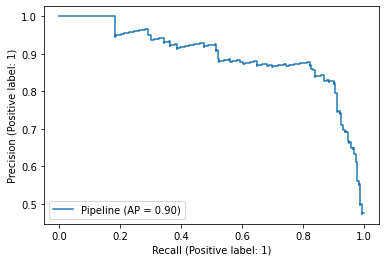

In [34]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df['comment'], y=test_df['toxic'])

In [35]:
np.where(prec > 0.95)

(array([344, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,
        359, 360, 361, 362, 363, 364, 369, 370, 371, 372, 373, 374, 375,
        376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
        389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401,
        402, 403, 404, 405]),)

In [37]:
thresholds[374]

0.8306724086480655

In [38]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict_proba(test_df['comment'])[:, 1] > thresholds[374])

1.0

In [39]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict_proba(test_df['comment'])[:, 1] > thresholds[374])

0.15625

In [ ]:
# низкий, нужно улучшать. Но выполнено условие для precision. Baseline.
# подберем гиперпараметры

In [42]:
grid_pipeline = Pipeline(
    [
        ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
        ('model', 
          GridSearchCV(
            LogisticRegression(random_state=0),
            param_grid={'C': [0.1, 1, 10.]},
            cv=3,
            verbose=4
            )
        )
    ]
)

In [43]:
grid_pipeline.fit(train_df['comment'], train_df['toxic'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.688 total time=   0.4s
[CV 2/3] END .............................C=0.1;, score=0.687 total time=   0.3s
[CV 3/3] END .............................C=0.1;, score=0.689 total time=   0.4s
[CV 1/3] END ...............................C=1;, score=0.832 total time=   0.4s
[CV 2/3] END ...............................C=1;, score=0.845 total time=   0.5s
[CV 3/3] END ...............................C=1;, score=0.839 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/3] END ............................C=10.0;, score=0.862 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/3] END ............................C=10.0;, score=0.870 total time=   0.9s
[CV 3/3] END ............................C=10.0;, score=0.870 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fe7d3340680>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [46]:
model_pipeline_c_10 = Pipeline(
    [
        ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
        ('model', LogisticRegression(random_state=0, C=10., max_iter=5000))
    ]
)

In [47]:
model_pipeline_c_10.fit(train_df['comment'], train_df['toxic'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7fe7d33208c0>)),
                ('model',
                 LogisticRegression(C=10.0, max_iter=5000, random_state=0))])

In [48]:
prec_c10, rec_c10, thresholds_c10 = precision_recall_curve(y_true=test_df['toxic'], probas_pred=model_pipeline_c_10.predict_proba(test_df['comment'])[:, 1])

In [49]:
np.where(prec_c10 > 0.95)

(array([333, 334, 335, 336, 337, 338, 339, 341, 342, 343, 344, 345, 346,
        347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
        369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
        382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394,
        395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
        408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420]),)

In [53]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeline_c_10.predict_proba(test_df['comment'])[:, 1] > thresholds_c10[333])

0.9534883720930233

In [54]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeline_c_10.predict_proba(test_df['comment'])[:, 1] > thresholds_c10[333])

0.4270833333333333

In [ ]:
# больше чем в 2 раза нашли негативных комментариев, сохранив precision